In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
import datetime
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import mlflow
from mlflow.models import infer_signature
from mlflow.data.pandas_dataset import PandasDataset
from mlflow import MlflowClient
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import os


In [2]:
#Connection à la BDD en local
#Pour des raisons de performance, certain feature on été calculé directement en SQL (compter le nombre de mots dans les descriptions etc...)
#les différentes requêtes SQL sont disponibles dans le dossier SQl
try:
    connection = mariadb.connect(
        user="root",
        password="root",
        host="127.0.0.1",
        port=3306,
        database="tawos_cleaned"

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

In [3]:
#création d'une méthode pour la récupération des colonnes / valeurs de la tables data_cleaned2
def get_rows(db):
    cur  = db.cursor()
    columns = []
    cur.execute("SELECT `COLUMN_NAME` FROM `INFORMATION_SCHEMA`.`COLUMNS` WHERE `TABLE_SCHEMA`='tawos_cleaned' AND `TABLE_NAME`='data_cleaned2'")
    for c in cur:
        columns.append(c[0])
    cur.close()
    
    cur = db.cursor()
    cur.execute(
        "SELECT * FROM data_cleaned2"
    )
    items = []
    for v in cur:
        items.append(v)
    cur.close()
    return columns, items

In [4]:
columns, issues = get_rows(connection)

In [5]:
#vérification sur le nombre de colonne / issue
print(len(columns),len(issues))

33 458232


In [26]:
#chargement des valeurs dans un dataframe
df = pd.DataFrame(issues, columns=columns)
# distinct sur les statuts pour voir les differentes valeurs
df['Status'].unique() 

array(['To Do', 'Done', 'In PR', 'In Progress', 'Open', 'Closed',
       'Resolved', 'Waiting for Feedback', 'New', 'In Development',
       'Waiting for Review', 'To Be Tested', 'Testing In Progress', 'Raw',
       'Ready for Development', 'Refine', 'Ready to Groom', 'Accepted',
       'Reviewable', 'Patch Available', 'Reopened', 'In Review',
       'Gathering Interest', 'Needs Triage', 'Long Term Backlog',
       'Short Term Backlog', 'Gathering Impact', 'Under Consideration',
       'Future Consideration', 'Waiting for Release',
       'Not Being Considered', 'Reviewing', 'Awaiting Release',
       'Published', 'Awaiting Merge', 'Complete', 'Backlog', 'Planning',
       'To Test', 'Code Review', 'To Develop', 'Unverified',
       'In CR Review', 'Returned', 'Reviewed', 'Invalid', "Won't Fix",
       'Selected for Development', 'Debugging With Submitter',
       'Ready for Work', 'Scoping', 'In Code Review', 'Investigating',
       'Waiting (Blocked)', 'Waiting for Reporter', 'Schedu

In [27]:
#preparation des colonnes à encoder / supprimer
columns_to_drop = ['Description_Changed_After_Estimation',  'ID', 'Jira_ID', 'Issue_Key', 'Creator_ID', 'Reporter_ID', 'Assignee_ID', 'Project_ID', 'Sprint_ID',  'URL', 'Title', 'Description', 'Description_Text', 'Description_Code', 'Pull_Request_URL', 'Timespent', 'Story_Point', 'Estimation_Date', 'Resolution_Date', 'Resolution', 'Creation_Date', 'Last_Updated']
columns_to_hot = ['Type', 'Priority']

In [28]:
#méthode pour convertir les dates en trimestre
def dt_to_qarter(x):
    d = datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    return pd.Timestamp(d).quarter
    
#Méthode pour compter le nombre de mot dans un texte via une librairie orientée NLP => abandonné fait en sql
def count_words_nlp(x):
    words = word_tokenize(x)
    return len(words)

In [29]:
# Application du trimestre sur la date de création du ticket
df['trimestre_creation'] = df['Creation_Date'].apply(dt_to_qarter)
# Application du trimestre sur la date de la dernière modification
df['trimestre_last_update'] = df['Last_Updated'].apply(dt_to_qarter)

In [79]:
# Nombre de mot dans la description via une lib nlp
#df['nb_word_description'] = df['Description'].apply(count_words_nlp)

In [30]:
# encodage des datas

cat_encoder = OneHotEncoder()
encoded = cat_encoder.fit_transform(df[ columns_to_hot ])
output = pd.DataFrame(encoded.toarray(), columns=cat_encoder.get_feature_names_out(), index=df[ columns_to_hot ].index)

df = pd.concat([df, output], axis=1)

# encodage des labels
le = LabelEncoder()
le.fit(df['Status'].unique())

labels = le.classes_

df['target'] = le.transform(df['Status']) #changement du libellé de statut à target

In [31]:
#définition du resultat en fonction des status Ok = 1 ou Down = 0

def convert_target(x):
    return int(labels[x] in ['Done', 'Resolved', 'Complete'])

df['target'] = df['target'].apply(convert_target)

In [32]:
#suppression des colonnes inutiles

df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(columns_to_hot,axis=1)
df_cleaned = df_cleaned.drop(columns_to_drop,axis=1)
df_cleaned = df_cleaned.drop('In_Progress_Minutes',axis=1)
df_cleaned = df_cleaned.drop('Resolution_Time_Minutes',axis=1)

df_cleaned = df_cleaned.drop(['Status'], axis=1)

In [93]:
#cette cellule a servis pour les tests suivant en supprimant les features afin de ne garder que les 6 avec le plus de poids

#df_cleaned = df_cleaned[['Resolution_Time_Minutes','lastUpdated_month','description_wordcount','Total_Effort_Minutes','created_month','In_Progress_Minutes','Priority_Medium','target']]
#print(df_cleaned)

        Resolution_Time_Minutes  lastUpdated_month  description_wordcount  \
0                           0.0                  7                     24   
1                           0.0                  6                    178   
2                           0.0                  5                     97   
3                           0.0                  3                      2   
4                           0.0                  3                    222   
...                         ...                ...                    ...   
458227                 138672.0                  7                     12   
458228                 464428.0                  7                     38   
458229                  69426.0                  2                     17   
458230                 198870.0                  8                      1   
458231                   1486.0                  8                      1   

        Total_Effort_Minutes  created_month  In_Progress_Minutes  \
0      

In [33]:
#vérification de la répartion des classes et équilibrages pour éviter les biais (cela réduit considérablement le jeu de donnée => faire des tests sans équilibrage)
class_0 = df_cleaned[df_cleaned['target'] == 0  ]
class_1 = df_cleaned[df_cleaned['target'] == 1  ]
class_0_under = class_0.sample( len(class_1) )

<Axes: title={'center': 'Avant - count (target)'}, xlabel='target'>

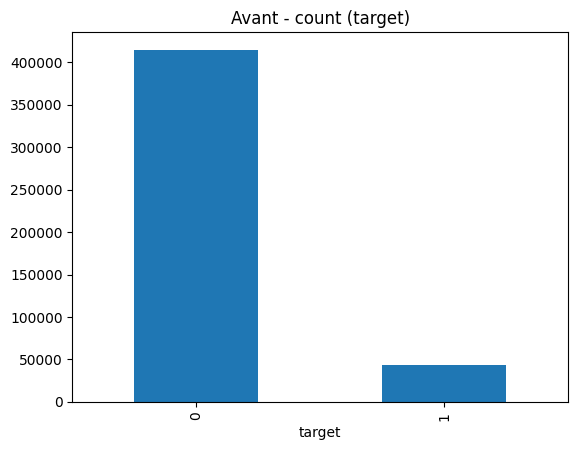

In [34]:
df_reduced = pd.concat([class_0_under, class_1], axis=0)
df_cleaned['target'].value_counts().plot(kind='bar', title='Avant - count (target)')

In [211]:
#test de ne pas équilibrer les classes mais d'avoir plus de data => resultat dans le mlflow => projetJiraSansEquilibrage
#df_reduced =df_cleaned

<Axes: title={'center': 'Après - count (target)'}, xlabel='target'>

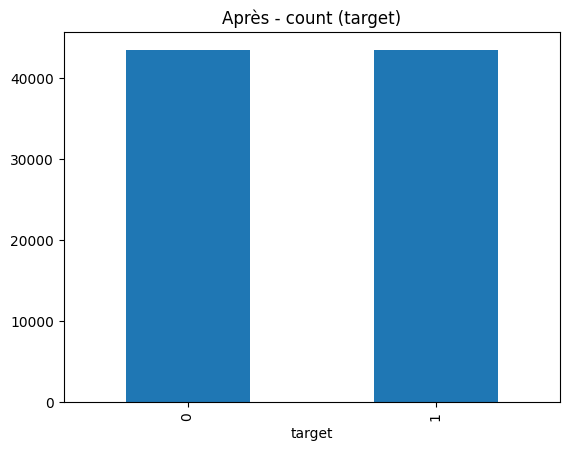

In [35]:
#verif de l'équilibrage
df_reduced['target'].value_counts().plot(kind='bar', title='Après - count (target)')

In [36]:
scaler =  Normalizer()
y = df_reduced['target']
X = df_reduced.drop(['target'], axis=1)
X_scaled = scaler.fit_transform(X, y)

print('Contrôle de la normalisation, données sont bien comprise entre 0 et 1 ?')
print('min', np.min(X_scaled))
print('max', np.max(X_scaled))

Contrôle de la normalisation, données sont bien comprise entre 0 et 1 ?
min 0.0
max 0.9999999999979069


In [37]:
#séparation des données pour le train / test / val => plusieurs répartitions ont été effectuées pour voir les immpacts sur l'apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.9)
X_test, X_val,  y_test, y_val  = train_test_split(X_test, y_test,train_size=0.8)

print(len(X_train))
print(len(X_test))
print(len(X_val))


78343
6964
1741


2024/09/12 15:17:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5567df612add45c2a2d31eb2868643f8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/09/12 15:17:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ANTOINE.SARAZIN\.conda\envs\py39\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mis

0.6977311889718553
0.697874784606548


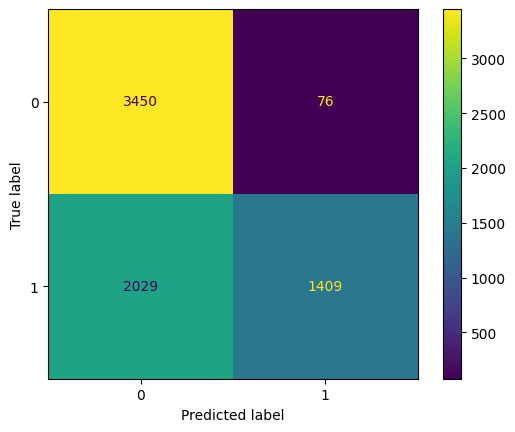

In [38]:
#les différents modèles ci-dessous ont été utilisé pour faire des tests rapides et faciliter les ajustements de paramètres avant de lancer les modèles 
# et de les tracer dans MlFlow

#model Decisiontree

dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test)  
dtree_Valpredictions = dtree_model.predict(X_val)  

print(accuracy_score(y_test,dtree_predictions))
print(accuracy_score(y_val,dtree_Valpredictions))

cm_dtree = confusion_matrix(y_test, dtree_predictions) 
cm_dtree_display = ConfusionMatrixDisplay(confusion_matrix = cm_dtree, display_labels = [0,1])

cm_dtree_display.plot()
plt.show()

In [39]:
#model de regressionLogistic

lg_model = LogisticRegression(random_state=123, solver='liblinear', max_iter=1000).fit(X_train, y_train)
lg_predictions = lg_model.predict(X_test)
lg_predictionsVal = lg_model.predict(X_val)
print(accuracy_score(y_test,lg_predictions))
print(accuracy_score(y_val,lg_predictionsVal))


2024/09/12 15:17:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd7c0f1055494472aa43da939486f6e8b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/09/12 15:18:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ANTOINE.SARAZIN\.conda\envs\py39\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mis

0.8199310740953475
0.8116025272831706


In [ ]:
#model support vector machine => en cours
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

#svm_model = SVC().fit(X_train, y_train)
svm_prediction = svm_model.predict(X_test)
svm_Valprediction = svm_model.predict(XVal)

print(accuracy_score(y_test,svm_prediction))
print(accuracy_score(yVal,svm_Valprediction))

2024/09/12 15:18:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '435e9a02f12442f7b5c9a658ca277aa4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/09/12 15:18:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ANTOINE.SARAZIN\.conda\envs\py39\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mis

0.901062607696726
0.8897185525560023


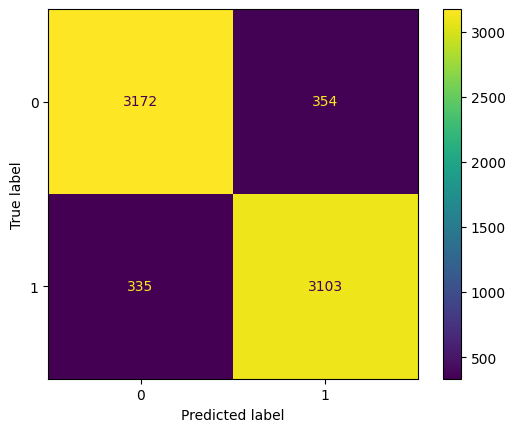

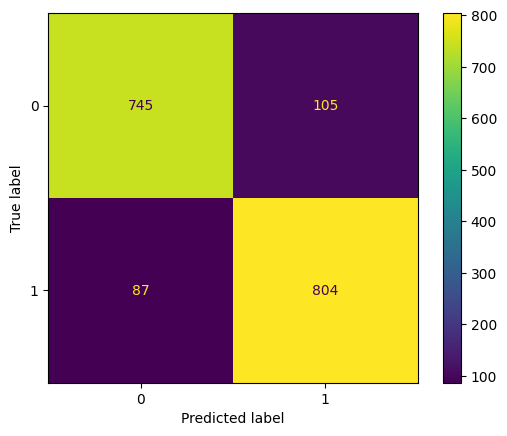

In [40]:
#modele XGBOOST

xgbmodel = XGBClassifier()


xgbmodel.fit(X_train, y_train)
xg_prediction = xgbmodel.predict(X_test)
xg_predictionVal = xgbmodel.predict(X_val)

#yval_predX = model.predict(Xval)
print(accuracy_score(y_test,xg_prediction))
print(accuracy_score(y_val,xg_predictionVal))


cm_xgb = confusion_matrix(y_test, xg_prediction) 
cm_xgb_display = ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = [0,1])

cm_xgb_display.plot()
plt.show()

cm_xgbVal = confusion_matrix(y_val, xg_predictionVal) 
cm_xgb_displayVal = ConfusionMatrixDisplay(confusion_matrix = cm_xgbVal, display_labels = [0,1])

cm_xgb_displayVal.plot()
plt.show()

2024/09/12 15:18:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3622c44e202547b8ac665ce1bb05501e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/09/12 15:18:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ANTOINE.SARAZIN\.conda\envs\py39\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mis

0.8934520390580126
0.8730614589316484


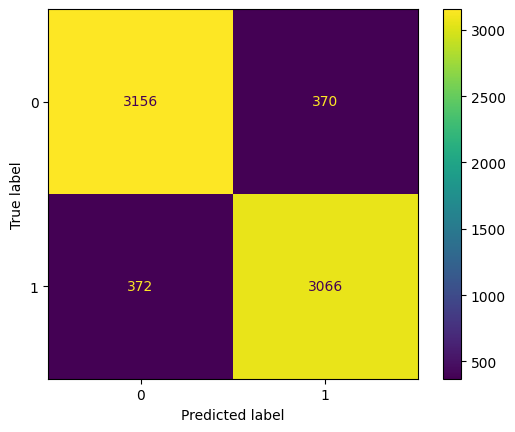

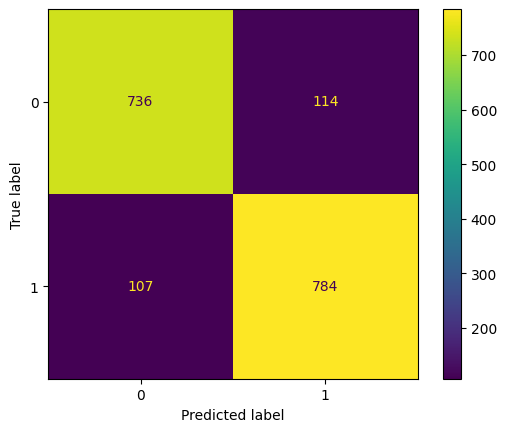

In [41]:
#modele randomForest

rfcmodel = RandomForestClassifier().fit(X_train, y_train)



rfc_prediction = rfcmodel.predict(X_test)
rfc_predictionVal = rfcmodel.predict(X_val)

#yval_predX = model.predict(Xval)
print(accuracy_score(y_test,rfc_prediction))
print(accuracy_score(y_val,rfc_predictionVal))


cm_rfc = confusion_matrix(y_test, rfc_prediction) 
cm_rfc_display = ConfusionMatrixDisplay(confusion_matrix = cm_rfc, display_labels = [0,1])

cm_rfc_display.plot()
plt.show()


cm_rfcVal = confusion_matrix(y_val, rfc_predictionVal) 
cm_rfc_displayVal = ConfusionMatrixDisplay(confusion_matrix = cm_rfcVal, display_labels = [0,1])

cm_rfc_displayVal.plot()
plt.show()

In [42]:
list_models = []

In [82]:
# cellule pour ajouter des nouveaux modèles dans la liste pour le tracking MlFlow / changer des paramètres rapidement
params_xgb = {
    "n_estimators":5,
    "max_depth":50,
    "learning_rate": 0.5,
    "objective": "binary:logistic",
}
bst = XGBClassifier(**params_xgb)
list_models.append(["XGBoost3",params_xgb,bst,mlflow.xgboost.autolog])#,model_info])

In [44]:
#tab pour le dataset sous MLflow
type_of_dataset = "Jira5"

###---------------------------------------------Descision Tree------------------------------------------------------------------####
params_lr = {
    "max_depth": 5,
}
# Create model instance
lr = DecisionTreeClassifier(**params_lr)

# Register in list 
list_models.append(["decisionTreeCL",params_lr,lr,mlflow.sklearn.autolog])#,model_info])


###---------------------------------------------Logistic regression------------------------------------------------------------------####
params_lr = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

# Create model instance
lr = LogisticRegression(**params_lr)

# Register in list 
list_models.append(["LogisticRegression",params_lr,lr,mlflow.sklearn.autolog])#,model_info])

###---------------------------------------------XGBOOST------------------------------------------------------------------####
params_xgb = {
    "n_estimators":5,
    "max_depth":10,
    "learning_rate": 0.3,
    "objective": "binary:logistic",
}

# Create model instance
bst = XGBClassifier(**params_xgb)

# Register in list 
list_models.append(["XGBoost2",params_xgb,bst,mlflow.xgboost.autolog])#,model_info])

###---------------------------------------------Random Forest------------------------------------------------------------------####

from sklearn.ensemble import RandomForestClassifier
params_rf = {
    "n_estimators":100,
    "criterion":"log_loss",
    "max_leaf_nodes":5
}
rf = RandomForestClassifier(**params_rf)
list_models.append(["RandomForest3",params_rf,rf,mlflow.sklearn.autolog])#,model_info])def eval_metrics(actual, preds):


def eval_metrics(actual, preds):
    accuracy = accuracy_score(actual, preds)
    recall = recall_score(actual, preds)
    precision = precision_score(actual, preds)
    cnf_matr = confusion_matrix(actual,preds)
    cnf_matr_nm = cnf_matr.astype('float') / cnf_matr.sum(axis=1)[:, np.newaxis]

    return accuracy, recall, precision, cnf_matr_nm

In [45]:
#Paramètrage de l'url pour lancer en localhost
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

#Nom à changer pour les différents tests NB: mettre un nom significatif
mlflow.set_experiment("XPReducedHightWeigthFeature")

for name,params,model,log_model in list_models:

#TODO : Voir pour ajouter les metrics pour la validation => sur les experiences postProd ?
    with mlflow.start_run():
        
        log_model()
        mlflow.log_params(params)
        model.fit(X_train, y_train)

        log_model(disable=True)
        preds_train = model.predict(X_train)


        accuracy_train, recall_train, precision_train, cnf_matr_train = eval_metrics(y_train,preds_train)
        mlflow.log_metric("accuracy_train", accuracy_train)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("precision_train", precision_train)

        fig, ax = plt.subplots()

        sns.heatmap(cnf_matr_train, annot=True)
        ax.set_title("Normalized confusion Matrix Train Set", fontsize=14)
        plt.xlabel('Predicted Label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.close(fig)

        mlflow.log_figure(fig, "normalized_confusion_matrix_train.png")
        
        log_model(disable=False)

        preds_test = model.predict(X_test)


        accuracy_test, recall_test, precision_test, cnf_matr_test = eval_metrics(y_test,preds_test)
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("precision_test", precision_test)
        fig, ax = plt.subplots()

        sns.heatmap(cnf_matr_test, annot=True)
        ax.set_title("Normalized confusion Matrix Test Set", fontsize=14)
        plt.xlabel('Predicted Label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.close(fig)

        mlflow.log_figure(fig, "normalized_confusion_matrix_test.png")


        mlflow.set_tag("Training Info", f"{name} model training for {type_of_dataset} titanic dataset")


        mlflow.set_tag("mlflow.runName", f"{name}")

2024/09/12 15:20:02 INFO mlflow.tracking.fluent: Experiment with name 'XPReducedHightWeigthFeature' does not exist. Creating a new experiment.
2024/09/12 15:20:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/09/12 15:20:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ANTOINE.SARAZIN\.conda\envs\py39\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decl

In [103]:
#Cette partie est pour simuler la récupération d'un modèle depuis MLFLOW avec la version souhaitée
model_name = "XGBOOST_REEDUCEDFEATURE" 
model_version = "1" 


model_uri = f"models:/{model_name}/{model_version}"
loaded_model = mlflow.pyfunc.load_model(model_uri)

In [157]:
#test d'une prédiction avec le modèle chargé

Resolution_Time_Minutes =50000.0
lastUpdated_month = 4 
description_wordcount = 5000
Total_Effort_Minutes = 550.0
created_month = 1
In_Progress_Minutes = 5000.0 
Priority_Medium =20.0

jira_data = pd.DataFrame([[Resolution_Time_Minutes,lastUpdated_month,description_wordcount,Total_Effort_Minutes,created_month,In_Progress_Minutes,Priority_Medium]],columns=["Resolution_Time_Minutes","lastUpdated_month","description_wordcount","Total_Effort_Minutes","created_month","In_Progress_Minutes","Priority_Medium"])

predict_result = loaded_model.predict(jira_data)


if predict_result == 0:
    print("Not Resolved")
else:
    print("Resolved")

good
